# Damage Assessment from image during natural disasters

Initial notebook to reproduce the results of the paper and try other models that could provide better performance.We wrote and experiment script and manually  try several experiments with VGG16 and EfficientNet.The final experiment module will be automated and reproducable in another script. 

For the AWS disaster response hackathon one of the challenge is to answer the question : **HOW MIGHT WE ACCURATELY AND EFFICIENTLY DETERMINE THE EXTENT OF DAMAGE TO INDIVIDUAL HOMES IN A GIVEN DISASTER-IMPACTED AREA ?**

To answer that question our team proposed to build and deploy an edge-based computer vision solution on smartphones for damage assessment.

In [ ]:
#!pip install tensorflow_addons

In [21]:
import os
import re
import pandas as pd
import numpy as np
import gc

import tensorflow as tf
from tensorflow.keras import optimizers, callbacks,models,layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

## Download the data

Images collected from Twitter during four natural disasters, namely Typhoon Ruby (2014), Nepal Earthquake (2015), Ecuador Earthquake (2016), and Hurricane Matthew (2016). In addition to Twitter images, it contains images collected from Google using queries such as "damage building", "damage bridge", and "damage road" to deal with labeled data scarcity problem. The images are labeled in 3 classes:
* Severe
* Mild
* None

In [ ]:
# !wget https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz

In [ ]:
#!tar -xvzf ASONAM17_Damage_Image_Dataset.tar.gz

## Get data and convert image path and label to csv

In [2]:
import csv
os.makedirs('./damage_csv',exist_ok=True)
images_path = './ASONAM17_Damage_Image_Dataset/'
data_dir_ecuador = os.path.join(images_path,'ecuador_eq')


def _get_train_files_by_event(images_path,event_file):
    files =[]
    for f in os.listdir(images_path):
        if not f.startswith('.'):
            if f.startswith(event_file) and os.path.isfile(os.path.join(images_path,f)):
                path = os.path.join(images_path,f)
                files.append(path)
    return files


def _get_train_file_data(file_path):
    data_raw_file = []
    with open(file_path,mode='r',encoding='utf-8') as f:
        for line in f.readlines():
            csvline = []
            image,label = line.split()
            csvline.append(image)
            csvline.append(int(label))
            data_raw_file.append(csvline)
    
    return data_raw_file



def _save_train_file_as_csv(event_file,data_raw_file,file_path):
    os.makedirs(f"./damage_csv/{event_file}/",exist_ok=True)
    if file_path.endswith('.dev'):
        file_csv = 'dev.csv'
    elif file_path.endswith('.train'):
        file_csv = 'train.csv'
    elif file_path.endswith('.test'):
        file_csv = 'test.csv'
        
    with open(f"./damage_csv/{event_file}/{file_csv}",mode='w',encoding='utf-8') as f:
        writer = csv.writer(f)
        for row in data_raw_file:
            writer.writerow(row)
        f.close()
        
## Save as CSV all data for an event

def save_all_files(images_path,event_file):
    files = _get_train_files_by_event(images_path,event_file)
    print(files)
    for f in files:
        data_file = _get_train_file_data(f)
        _save_train_file_as_csv(event_file,data_file,f) 

        

In [47]:
save_all_files(images_path,'ruby')

['./ASONAM17_Damage_Image_Dataset/ruby.dev', './ASONAM17_Damage_Image_Dataset/ruby.test', './ASONAM17_Damage_Image_Dataset/ruby.train']


## Load data in a Tensorflow Dataset

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

damage_path = './damage_csv'
IMG_SIZE = 224
batch_size = 32
num_classes = 3

data_augmentation_layer = tf.keras.Sequential([
                                  layers.RandomFlip("horizontal_and_vertical"),
                                  layers.RandomRotation(0.2),
                                  layers.RandomCrop(IMG_SIZE,IMG_SIZE),
                                  layers.RandomContrast(factor=0.8)
])

    
def create_dataset(damage_path,event,is_augment=False,batch_size=32,buffer_size=100):


    label_path = os.path.join(damage_path,event)
    
    img_gen = ImageDataGenerator(rescale=1/255.0,)
        
    train_df = pd.read_csv(os.path.join(label_path,'train.csv'),header=None)
    train_df.columns = ['path','label']

    train_gen = img_gen.flow_from_dataframe(dataframe = train_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',          
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))



    valid_df = pd.read_csv(os.path.join(label_path,'dev.csv'),header=None)
    valid_df.columns = ['path','label']

    valid_gen = img_gen.flow_from_dataframe(dataframe = valid_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',         
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))
    
    test_df = pd.read_csv(os.path.join(label_path,'test.csv'),header=None)
    test_df.columns = ['path','label']

    test_gen = img_gen.flow_from_dataframe(dataframe = test_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',         
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE)) 
      
    # Now we're converting our ImageDataGenerator to Dataset

    train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen ,  # Our generator 
            output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ]) # How we're expecting our output shape
        )

    valid_dataset = tf.data.Dataset.from_generator(
            lambda: valid_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )
    
    test_dataset = tf.data.Dataset.from_generator(
            lambda: test_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )

    if is_augment:
        train_dataset = train_dataset.map(lambda x,y: (data_augmentation_layer(x,training=True),y),
                                num_parallel_calls=tf.data.AUTOTUNE)
            
    print(f"steps_per_epochs: {len(train_df)// batch_size}")
    print(f"validations_steps: {len(valid_df)// batch_size}")
        
        
    steps_per_epoch = len(train_df)// batch_size
    validation_steps = len(valid_df)// batch_size


    train_dataset = train_dataset.prefetch(buffer_size=10)
    valid_dataset = valid_dataset.prefetch(buffer_size=10)

    return train_dataset,valid_dataset,test_dataset,steps_per_epoch,validation_steps
    
            


train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'ecuador',
                                    is_augment=True,batch_size=128,buffer_size=100)
    

    

Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3


In [5]:
class_names=['none','mild','severe']

## Visualize data

In [6]:
#image_batch, label_batch = next(iter(test_ds))

#plt.figure(figsize = (10, 10))
#for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(image_batch[i])
#    label = label_batch[i]
#    plt.title(class_names[int(label)])
#    plt.axis("off")

In [7]:
def subplot_learning_curve(model_name,history):
    #plt.clf()
    plt.figure(figsize=(10,5))
    for i,metric in enumerate(['acc','loss']):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend((metric, 'val_' + metric))
        plt.title(model_name + ": Learning curve " + metric + " vs " + 'val_' + metric)
    plt.show()

## Create Model Architecture

### VGG16 pre-trained

Remove the top classifications layers of VGG16 and freeze the bottom layers

In [73]:
from keras.applications.vgg16 import VGG16

def get_vgg16_model(lr= 0.001) :

    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")

    pre_trained_model = VGG16(include_top=False,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x = pre_trained_model(x,training= False)
    x = layers.Flatten()(x)   
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    vgg16_model = models.Model(inputs,outputs)
    vgg16_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    vgg16_model.summary()
    
    return vgg16_model


get_vgg16_model()

lr in model = 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                         

### VGG16_fc2

Remove the top output softmax layer of VGG16, replace it with a dense layer for only 3 classes
and freeze the bottom layers

In [71]:
from keras.applications.vgg16 import VGG16


def get_vgg16_fc2_model(lr = 0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")

    pre_trained_model = VGG16(include_top=True,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    # pre_trained_model.summary()
    for layer in pre_trained_model.layers:
        layer.trainable  = False

    last_layer = pre_trained_model.layers[-2]
    print("output shape :", last_layer.output_shape)

    last_output= last_layer.output
    x = layers.Dropout(0.3)(last_output)
    outputs = layers.Dense(num_classes,activation='softmax')(x)


    model2 = models.Model(pre_trained_model.input,outputs)
    model2.compile(optimizer=optimizers.Adam(learning_rate=lr),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['acc'])

    model2.summary()
    
    return model2

get_vgg16_fc2_model()

lr in model = 0.001
output shape : (None, 4096)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool 

### EfficientNet
Remove the top classifications layers of EfficientNet and freeze the bottom layers

In [72]:
from keras.applications.efficientnet import EfficientNetB0

def get_efficient_model(lr=0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")
    pre_trained_model = EfficientNetB0(include_top=False,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = pre_trained_model(x,training= False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    efficient_model = models.Model(inputs,outputs)
    efficient_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

    efficient_model.summary()
    
    return efficient_model

get_efficient_model()

lr in model = 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)   

### MobileNet
Remove the top output softmax layer of MobileNetV2, replace it with a dense layer for only 3 classes
and freeze the bottom layers

In [98]:
from keras.applications.mobilenet_v2 import MobileNetV2

def get_mobilenet_model(lr=0.001):
    
    tf.keras.backend.clear_session()
    print(f"lr in model = {lr}")
    pre_trained_model = MobileNetV2(include_top=True,
                                       weights='imagenet',
                                       input_shape=(IMG_SIZE,IMG_SIZE,3))

    pre_trained_model.trainable = False

    #inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    #x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    #x = pre_trained_model(x,training= False)
    #x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Dropout(0.2)(x)
    #outputs = layers.Dense(num_classes,activation='softmax')(x)

    #mobilenet_model = models.Model(inputs,outputs)
    #mobilenet_model.compile(optimizer = optimizers.Adam(learning_rate=lr),
                            #loss='sparse_categorical_crossentropy',
                            #metrics=['acc'])
    #pre_trained_model.summary()
    
    for layer in pre_trained_model.layers:
        layer.trainable  = False

    last_layer = pre_trained_model.layers[-2]
    print("output shape :", last_layer.output_shape)

    last_output= last_layer.output
    x = layers.Dropout(0.3)(last_output)
    outputs = layers.Dense(num_classes,activation='softmax')(x)


    model2 = models.Model(pre_trained_model.input,outputs)
    model2.compile(optimizer=optimizers.Adam(learning_rate=lr),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['acc'])

    model2.summary()
    
    return model2

get_mobilenet_model()

lr in model = 0.001
output shape : (None, 1280)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )             

## Create Experiment

In [31]:
def finetune_model(lr,model_name,train_batches,valid_batches,initial_epoch,
                   epochs, steps_per_epoch,validation_steps,use_clr=False,init_lr=1e-3,max_lr=1e-2,model=None):
    print(f"finetuning lr ={lr}")
    print(f"finetuning epochs ={epochs}")
    print(f"init LR epochs ={init_lr}")
    print(f"max LR epochs ={max_lr}")
    
    if use_clr:
        print("using cyclical LR for finetuning")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr      

    
    if model:
        for layer in model.layers:
            layer.trainable = True
        
        check = callbacks.ModelCheckpoint(f'./model/{model_name}.h5',save_best_only=True)
        early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

        model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['acc'])

        print()
        print("Training..................")
        history = model.fit(train_batches,
                        initial_epoch=initial_epoch,
                        epochs=epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=valid_batches,
                        validation_steps = validation_steps,
                        callbacks=[early_stop])
       
    return history, model

      
    
    

In [83]:

def run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=32,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=20,init_lr=1e-3,max_lr=1e-2):
    
    print(f"******************{exp_name}*********************************")
    print(f"model_name ={model_name}")
    print(f"data augmentation ={is_augment}")
    print(f"event ={event}")
    print(f"finetuning ={do_finetune}")
    print(f"lr ={lr}")
    print()
    
    gc.collect()

    print(f"Creating dataset.....")
    train_batches,valid_batches,test_batches,steps_per_epoch,validation_steps = create_dataset(damage_path,
                                                                                               event,
                                                                                  is_augment=is_augment,
                                                                                  batch_size= batch_size)
    
    if use_clr:
        print("using cyclical LR for training")
        clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
                maximal_learning_rate=max_lr,
                scale_fn=lambda x: 1/(1.**(x-1)),
                step_size= 2 * steps_per_epoch)
        lr = clr
   

    print("Model architecture...........")
    if model_name == 'vgg16':
        model = get_vgg16_model(lr=lr)
    if model_name == 'vgg16_fc2':
        model = get_vgg16_fc2_model(lr=lr)
    elif model_name =='efficientnet':
        model = get_efficient_model(lr=lr) 
    elif model_name =='mobilenet':
        model = get_mobilenet_model(lr=lr)

    check = callbacks.ModelCheckpoint(f'./model/{model_name}.h5',save_best_only=True)
    early_stop = callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

    print()
    print("Training..................")
    history = model.fit(train_batches,
                epochs=n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=valid_batches,
                validation_steps = validation_steps,
                callbacks=[check,early_stop])
    
    
    print()
    subplot_learning_curve(model_name,history)
    
    print()
    #print('loading best weights model')
    #model = models.load_model(f'./model/{model_name}.h5')

    print()
    print(f"Run evaluation.........")   
  
    results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
    results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)

    print()
    print(f"Training accuracy: {results_train['acc']}")
    print(f"Validation accuracy: {results_test['acc']}")
    
    if do_finetune:
        
        if not use_clr:
            #LR finetuning when not using CLR
            lr = lr * 1e-2
        print()
        print(f"******Fine tuning***********************")
        history, model = finetune_model(lr=lr,model_name=model_name,train_batches=train_batches,
                                        valid_batches=valid_batches, initial_epoch=n_epochs,epochs=2*n_epochs,
                                        steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,
                                        use_clr=use_clr,init_lr=init_lr * 1e-2,max_lr=max_lr * 1e-2,model=model)
        print()
        subplot_learning_curve(model_name+"_fintuned",history)
        
        results_train = model.evaluate(train_batches, steps = steps_per_epoch,return_dict=True)
        results_test = model.evaluate(valid_batches, steps = validation_steps, return_dict=True)
        
        print()
        print(f"Training finetune accuracy: {results_train['acc']}")
        print(f"Validation finetune accuracy: {results_test['acc']}")
        

    return results_train['acc'],results_test['acc'],model

## Running Training experiments

### VGG16 no augmentation

******************VGG16 No augmentation*********************************
model_name =vgg16
data augmentation =False
event =ecuador
finetuning =False
lr =0.001

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
Model architecture...........
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)      

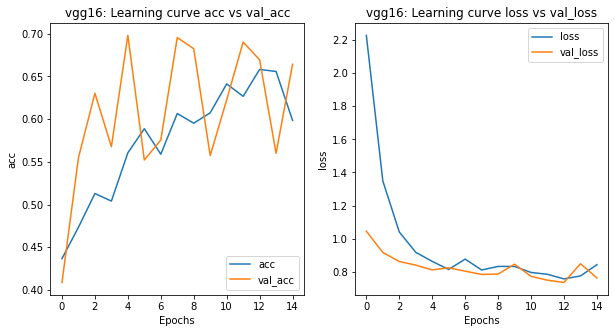



Run evaluation.........
3/3 [==============================] - 4s 894ms/step - loss: 0.8474 - acc: 0.6693

Training accuracy: 0.6870967745780945
Validation accuracy: 0.6692708134651184
CPU times: user 4min, sys: 22.5 s, total: 4min 23s
Wall time: 3min 4s


In [58]:
%%time
exp_name = 'VGG16 No augmentation'
event= 'ecuador'
model_name = 'vgg16'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=128,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=20,init_lr=1e-3,max_lr=1e-2)


### VGG16 with augmentation

******************VGG16 with augmentation*********************************
model_name =vgg16
data augmentation =True
event =ecuador
finetuning =False
lr =0.001

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
Model architecture...........
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)     

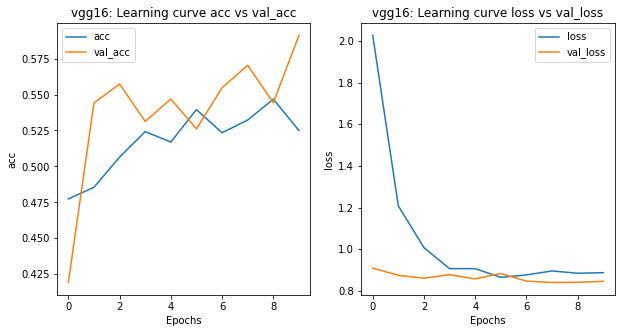



Run evaluation.........
3/3 [==============================] - 4s 1s/step - loss: 0.8693 - acc: 0.5755

Training accuracy: 0.5338709950447083
Validation accuracy: 0.5755208134651184
CPU times: user 4min 54s, sys: 42 s, total: 5min 37s
Wall time: 2min 29s


In [59]:
%%time
exp_name = 'VGG16 with augmentation'
event= 'ecuador'
model_name = 'vgg16'

rs = run_experiment(exp_name,event,model_name,is_augment=True,lr=0.001,batch_size=128,do_finetune=False,
                use_clr= False,buffer_size=20,n_epochs=10,init_lr=1e-3,max_lr=1e-2)

While data augmentation does have an explicit regularization effect, exploiting it can actually lead to the model not learning enough resulting in poor prediction results. Thus, we can see that there might be  a need to try out different combinations of data augmentation to find the most appropriate one for the data set of the problem statement

### VGG16 No augmentation, finetuned

******************VGG16 no augmentation, finetuned*********************************
model_name =vgg16
data augmentation =False
event =ecuador
finetuning =True
lr =0.003

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
Model architecture...........
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functio

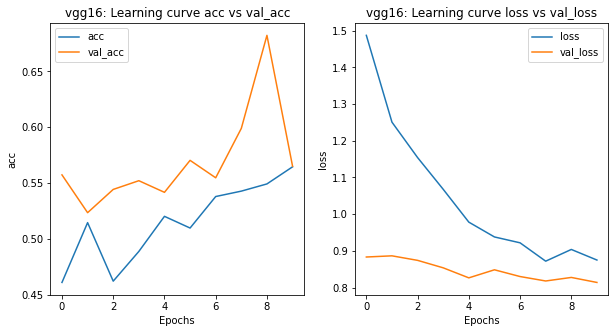



Run evaluation.........
3/3 [==============================] - 4s 1s/step - loss: 0.8194 - acc: 0.5625

Training accuracy: 0.5532258152961731
Validation accuracy: 0.5625

******Fine tuning***********************
finetuning lr =3e-05
finetuning epochs =20

Training..................
Epoch 11/20
10/10 [==============================] - 22s 2s/step - loss: 1.0390 - acc: 0.5089 - val_loss: 0.8549 - val_acc: 0.6875
Epoch 12/20
10/10 [==============================] - 19s 2s/step - loss: 0.8952 - acc: 0.5218 - val_loss: 0.8469 - val_acc: 0.5469
Epoch 13/20
10/10 [==============================] - 20s 2s/step - loss: 0.8421 - acc: 0.5847 - val_loss: 0.8227 - val_acc: 0.6979
Epoch 14/20
10/10 [==============================] - 20s 2s/step - loss: 0.8733 - acc: 0.5847 - val_loss: 1.0114 - val_acc: 0.5391
Epoch 15/20
10/10 [==============================] - 20s 2s/step - loss: 0.8857 - acc: 0.5645 - val_loss: 0.8050 - val_acc: 0.6875
Epoch 16/20
10/10 [==============================] - 20s 2s/

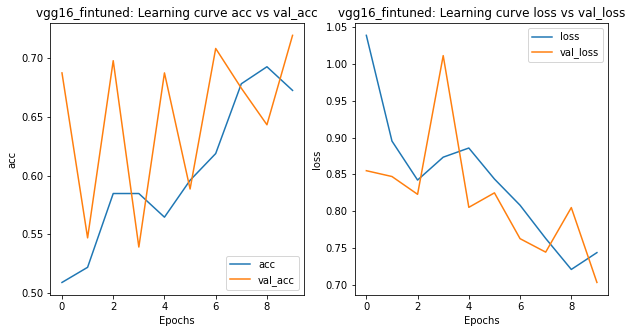

3/3 [==============================] - 3s 747ms/step - loss: 0.7235 - acc: 0.6982

Training finetune accuracy: 0.7387096881866455
Validation finetune accuracy: 0.6981707215309143
CPU times: user 7min 6s, sys: 1min 18s, total: 8min 24s
Wall time: 5min 58s


In [61]:
%%time
exp_name = 'VGG16 no augmentation, finetuned'
event= 'ecuador'
model_name = 'vgg16'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=3 * 1e-3,batch_size=128,do_finetune=True,
                use_clr= False,buffer_size=10,n_epochs=10,init_lr=1e-3,max_lr=1e-2)

### VGG16_fc2 no augmentation finetuned

******************VGG16_fc2 no augmentation*********************************
model_name =vgg16_fc2
data augmentation =False
event =ecuador
finetuning =True
lr =0.003

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
Model architecture...........
output shape : (None, 4096)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0

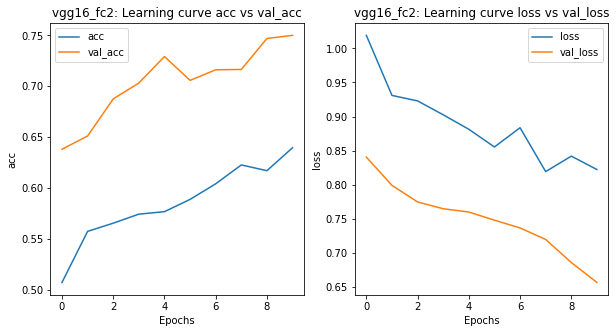



Run evaluation.........
3/3 [==============================] - 3s 734ms/step - loss: 0.7013 - acc: 0.7409

Training accuracy: 0.757031261920929
Validation accuracy: 0.7408536672592163

******Fine tuning***********************
finetuning lr =3e-05
finetuning epochs =20

Training..................
Epoch 11/20


2021-12-28 23:37:36.112209: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-28 23:37:36.113331: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 1/10 [==>...........................] - ETA: 34s - loss: 0.8598 - acc: 0.6406

2021-12-28 23:37:37.994100: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-28 23:37:37.994352: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 2/10 [=====>........................] - ETA: 15s - loss: 2.8076 - acc: 0.5117

2021-12-28 23:37:39.872235: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-28 23:37:39.872420: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 3/10 [========>.....................] - ETA: 13s - loss: 2.2323 - acc: 0.5078

2021-12-28 23:37:41.747432: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-28 23:37:41.747639: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


10/10 [==============================] - 27s 3s/step - loss: 1.8939 - acc: 0.5227 - val_loss: 0.7114 - val_acc: 0.7470
Epoch 12/20
10/10 [==============================] - 24s 3s/step - loss: 0.7057 - acc: 0.7226 - val_loss: 0.5068 - val_acc: 0.8049
Epoch 13/20
10/10 [==============================] - 23s 2s/step - loss: 0.5498 - acc: 0.8016 - val_loss: 0.4791 - val_acc: 0.8293
Epoch 14/20
10/10 [==============================] - 23s 2s/step - loss: 0.4583 - acc: 0.8177 - val_loss: 0.4979 - val_acc: 0.8293
Epoch 15/20
10/10 [==============================] - 23s 2s/step - loss: 0.3748 - acc: 0.8573 - val_loss: 0.3610 - val_acc: 0.8750
Epoch 16/20
10/10 [==============================] - 24s 2s/step - loss: 0.2887 - acc: 0.8992 - val_loss: 0.3437 - val_acc: 0.8841
Epoch 17/20
10/10 [==============================] - 24s 2s/step - loss: 0.1990 - acc: 0.9331 - val_loss: 0.2772 - val_acc: 0.9085
Epoch 18/20
10/10 [==============================] - 22s 2s/step - loss: 0.1578 - acc: 0.9468 -

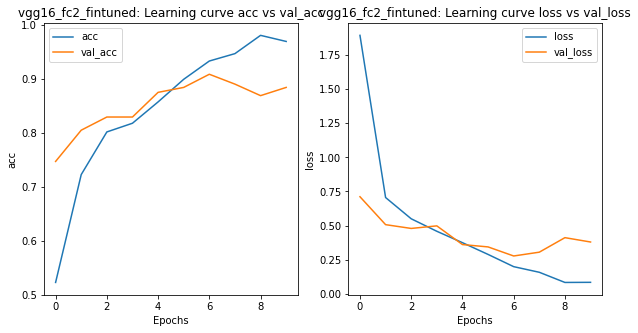

3/3 [==============================] - 3s 825ms/step - loss: 0.4309 - acc: 0.8598

Training finetune accuracy: 0.985156238079071
Validation finetune accuracy: 0.8597561120986938
CPU times: user 7min 15s, sys: 1min 36s, total: 8min 51s
Wall time: 6min 57s


In [63]:
%%time
exp_name = 'VGG16_fc2 no augmentation'
event= 'ecuador'
model_name = 'vgg16_fc2'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=3 * 1e-3,batch_size=128,do_finetune=True,
                use_clr= False,buffer_size=10,n_epochs=10,init_lr=1e-3,max_lr=1e-2)

### VGG16_fc2 no augmentation finetuned with CLR

******************VGG16_fc2 no augmentation*********************************
model_name =vgg16_fc2
data augmentation =False
event =ecuador
finetuning =True
lr =0.001

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
using cyclical LR for training
Model architecture...........
output shape : (None, 4096)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2

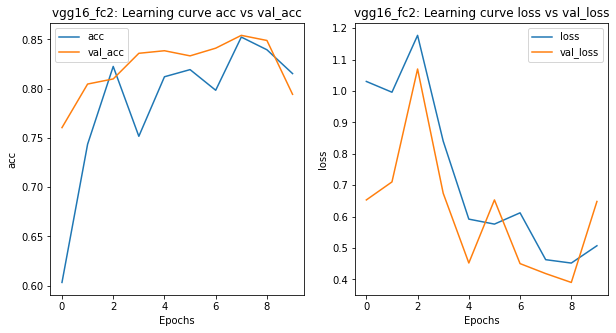



Run evaluation.........
3/3 [==============================] - 4s 1s/step - loss: 0.6762 - acc: 0.7786

Training accuracy: 0.7749999761581421
Validation accuracy: 0.7786458134651184

******Fine tuning***********************
finetuning lr =<tensorflow_addons.optimizers.cyclical_learning_rate.CyclicalLearningRate object at 0x7f77049c7820>
finetuning epochs =20
using cyclical LR for finetuning

Training..................
Epoch 11/20
10/10 [==============================] - 35s 4s/step - loss: 1.3126 - acc: 0.6653 - val_loss: 0.8728 - val_acc: 0.7344
Epoch 12/20
10/10 [==============================] - 33s 3s/step - loss: 0.5945 - acc: 0.7976 - val_loss: 0.6114 - val_acc: 0.7943
Epoch 13/20
10/10 [==============================] - 33s 3s/step - loss: 0.4193 - acc: 0.8532 - val_loss: 0.4075 - val_acc: 0.8568
Epoch 14/20
10/10 [==============================] - 32s 3s/step - loss: 0.3071 - acc: 0.8944 - val_loss: 0.3690 - val_acc: 0.8776
Epoch 15/20
10/10 [==============================] -

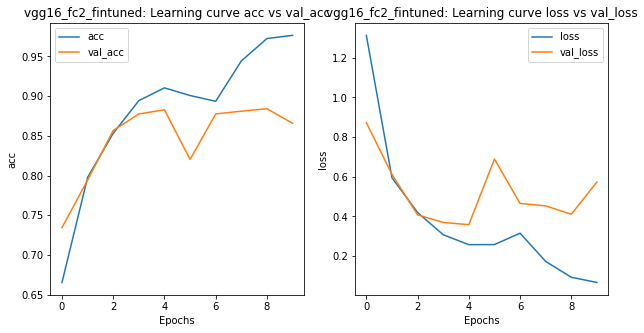

3/3 [==============================] - 3s 868ms/step - loss: 0.6181 - acc: 0.8598

Training finetune accuracy: 0.9887096881866455
Validation finetune accuracy: 0.8597561120986938
CPU times: user 7min 59s, sys: 2min, total: 10min
Wall time: 8min 10s


In [65]:
%%time
exp_name = 'VGG16_fc2 no augmentation'
event= 'ecuador'
model_name = 'vgg16_fc2'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=128,do_finetune=True,
                use_clr= True,buffer_size=10,n_epochs=10,init_lr=1e-3,max_lr=1e-2)

### Find optimal learning rate

In [26]:
from tensorflow import keras
K = tf.keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X,num_train, epochs=1, batch_size=32, min_rate=10**-6, max_rate=10):
    init_weights = model.get_weights()
    #iterations = len(X) * epochs
    iterations = num_train * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, 
                        steps_per_epoch = steps_per_epoch,
                        epochs=epochs,
                        validation_steps = validation_steps,
                        batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [15]:
train_batches, valid_batches,steps_per_epoch,validation_steps,num_train,num_valid = create_dataset(damage_path,'ecuador',img_data_gen= False,
                                    is_rescale=True,is_augment=False,batch_size=128,buffer_size=100)

#rates, losses = find_learning_rate(model2, train_batches, steps_per_epoch,epochs=1, batch_size=128)


Found 1368 validated image filenames.
Found 456 validated image filenames.
returned datasets
steps_per_epochs: 10
validations_steps: 3


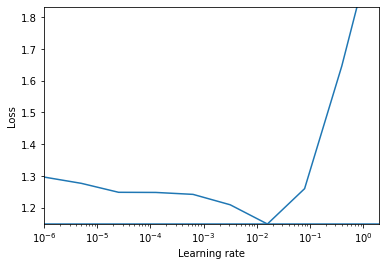

In [29]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    #plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses))*3/4])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

plot_lr_vs_loss(rates, losses)

In [16]:
train_batches, valid_batches,steps_per_epoch,validation_steps,num_train,num_valid = create_dataset(damage_path,'ecuador',img_data_gen= False,
                                    is_rescale=True,is_augment=False,batch_size=128,buffer_size=100)

Found 1368 validated image filenames.
Found 456 validated image filenames.
returned datasets
steps_per_epochs: 10
validations_steps: 3


### EfficientNet no augmentation

******************EfficientNet no augmentation*********************************
model_name =efficientnet
data augmentation =False
event =ecuador
finetuning =False
lr =0.001

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
Model architecture...........
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_ave

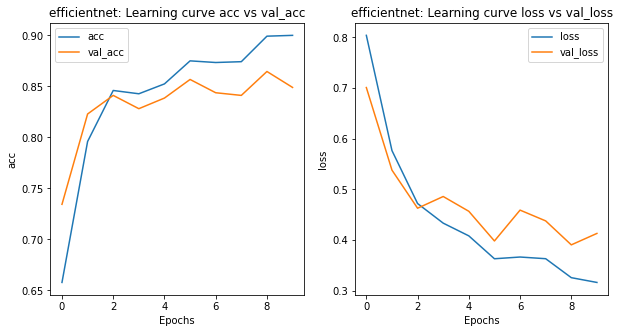



Run evaluation.........
3/3 [==============================] - 4s 1s/step - loss: 0.4288 - acc: 0.8490

Training accuracy: 0.8943548202514648
Validation accuracy: 0.8489583134651184
CPU times: user 2min 50s, sys: 13.8 s, total: 3min 3s
Wall time: 2min 13s


In [66]:
%%time
exp_name = 'EfficientNet no augmentation'
event= 'ecuador'
model_name = 'efficientnet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=128,do_finetune=False,
                use_clr= False,buffer_size=10,n_epochs=10,init_lr=1e-3,max_lr=1e-2)

### EfficientNet no augmentation, finetuned 

******************EfficientNet no augmentation*********************************
model_name =efficientnet
data augmentation =False
event =ecuador
finetuning =True
lr =0.001

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
Model architecture...........
lr in model = 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                          

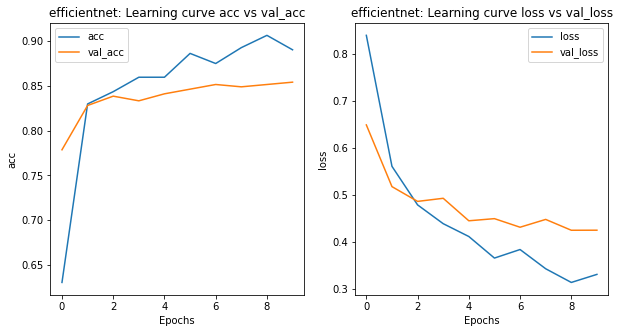



Run evaluation.........
3/3 [==============================] - 3s 935ms/step - loss: 0.4044 - acc: 0.8646

Training accuracy: 0.899193525314331
Validation accuracy: 0.8645833134651184

******Fine tuning***********************
finetuning lr =1e-05
finetuning epochs =20

Training..................
Epoch 11/20
10/10 [==============================] - 24s 2s/step - loss: 0.2903 - acc: 0.9081 - val_loss: 0.4060 - val_acc: 0.8542
Epoch 12/20
10/10 [==============================] - 16s 2s/step - loss: 0.2871 - acc: 0.9073 - val_loss: 0.4067 - val_acc: 0.8542
Epoch 13/20
10/10 [==============================] - 16s 2s/step - loss: 0.3003 - acc: 0.8984 - val_loss: 0.4256 - val_acc: 0.8516
Epoch 14/20
10/10 [==============================] - 16s 2s/step - loss: 0.2603 - acc: 0.9234 - val_loss: 0.3889 - val_acc: 0.8594
Epoch 15/20
10/10 [==============================] - 16s 2s/step - loss: 0.2520 - acc: 0.9218 - val_loss: 0.4089 - val_acc: 0.8542
Epoch 16/20
10/10 [===========================

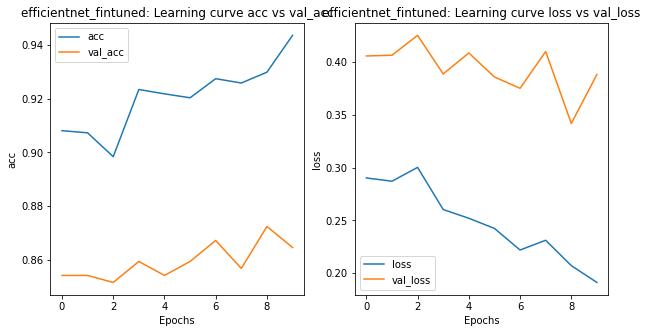

3/3 [==============================] - 4s 1s/step - loss: 0.3686 - acc: 0.8724

Training finetune accuracy: 0.949999988079071
Validation finetune accuracy: 0.8723958134651184
CPU times: user 6min 45s, sys: 1min, total: 7min 46s
Wall time: 5min 13s


In [74]:
%%time
exp_name = 'EfficientNet no augmentation'
event= 'ecuador'
model_name = 'efficientnet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=1e-3,batch_size=128,do_finetune=True,
                use_clr= False,buffer_size=10,n_epochs=10,init_lr=1e-3,max_lr=1e-2)

### EfficientNet no augmentation, finetuned with CLR

******************EfficientNet no augmentation*********************************
model_name =efficientnet
data augmentation =False
event =ecuador
finetuning =True
lr =0.001

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
using cyclical LR for training
Model architecture...........
lr in model = <tensorflow_addons.optimizers.cyclical_learning_rate.CyclicalLearningRate object at 0x7f733b2b2730>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 

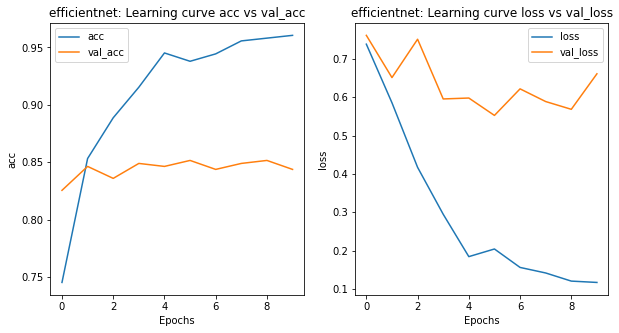



Run evaluation.........
3/3 [==============================] - 4s 1s/step - loss: 0.6092 - acc: 0.8542

Training accuracy: 0.977419376373291
Validation accuracy: 0.8541666865348816

******Fine tuning***********************
finetuning lr =<tensorflow_addons.optimizers.cyclical_learning_rate.CyclicalLearningRate object at 0x7f733b2b2730>
finetuning epochs =20
using cyclical LR for finetuning

Training..................
Epoch 11/20
10/10 [==============================] - 25s 2s/step - loss: 0.1686 - acc: 0.9492 - val_loss: 0.5889 - val_acc: 0.8568
Epoch 12/20
10/10 [==============================] - 16s 2s/step - loss: 0.1694 - acc: 0.9500 - val_loss: 0.5944 - val_acc: 0.8073
Epoch 13/20
10/10 [==============================] - 16s 2s/step - loss: 0.1439 - acc: 0.9516 - val_loss: 0.5587 - val_acc: 0.8724
Epoch 14/20
10/10 [==============================] - 16s 2s/step - loss: 0.0760 - acc: 0.9815 - val_loss: 0.5093 - val_acc: 0.8906
Epoch 15/20
10/10 [==============================] - 

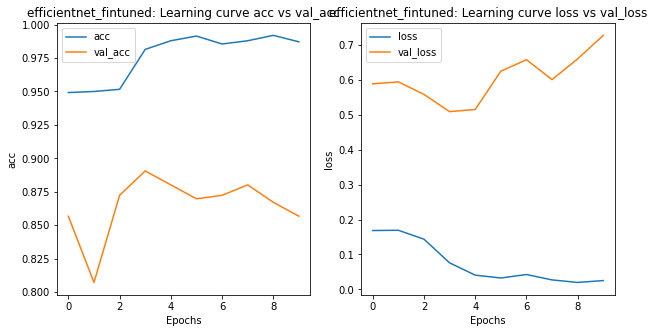

3/3 [==============================] - 4s 1s/step - loss: 0.6992 - acc: 0.8620

Training finetune accuracy: 0.9911290407180786
Validation finetune accuracy: 0.8619791865348816
CPU times: user 6min 46s, sys: 1min 1s, total: 7min 48s
Wall time: 5min 15s


In [75]:
%%time
exp_name = 'EfficientNet no augmentation'
event= 'ecuador'
model_name = 'efficientnet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=0.001,batch_size=128,do_finetune=True,
                use_clr= True,buffer_size=10,n_epochs=10,init_lr=5 * 1e-3,max_lr=5 * 1e-2)

### MobileNetV2 no augmentation

******************MobileNet V2 no augmentation*********************************
model_name =mobilenet
data augmentation =False
event =ecuador
finetuning =True
lr =0.001

Creating dataset.....
Found 1368 validated image filenames.
Found 456 validated image filenames.
Found 456 validated image filenames.
steps_per_epochs: 10
validations_steps: 3
Model architecture...........
lr in model = 0.001
output shape : (None, 1280)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         [

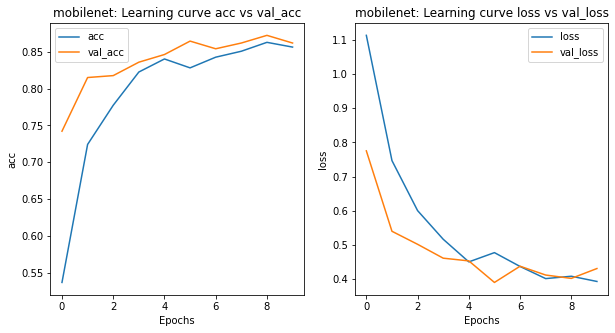



Run evaluation.........
3/3 [==============================] - 4s 1s/step - loss: 0.3947 - acc: 0.8776

Training accuracy: 0.8822580575942993
Validation accuracy: 0.8776041865348816

******Fine tuning***********************
finetuning lr =1e-05
finetuning epochs =20

Training..................
Epoch 11/20
10/10 [==============================] - 20s 2s/step - loss: 1.2659 - acc: 0.5056 - val_loss: 0.4246 - val_acc: 0.8594
Epoch 12/20
10/10 [==============================] - 12s 1s/step - loss: 1.0136 - acc: 0.5903 - val_loss: 0.4357 - val_acc: 0.8594
Epoch 13/20
10/10 [==============================] - 12s 1s/step - loss: 0.9542 - acc: 0.6274 - val_loss: 0.4655 - val_acc: 0.8490
Epoch 14/20
10/10 [==============================] - 13s 1s/step - loss: 0.7135 - acc: 0.7145 - val_loss: 0.5219 - val_acc: 0.8438
Epoch 15/20
10/10 [==============================] - 12s 1s/step - loss: 0.6337 - acc: 0.7589 - val_loss: 0.5456 - val_acc: 0.8411
Epoch 16/20
10/10 [=============================

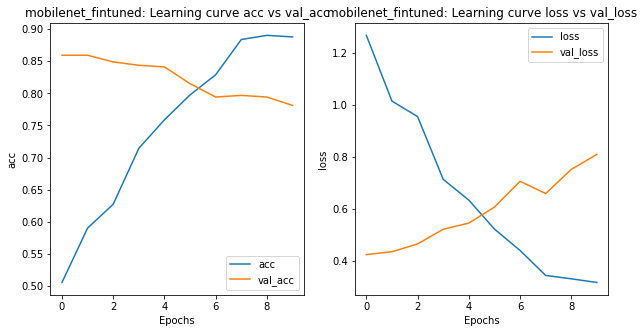

3/3 [==============================] - 3s 1s/step - loss: 0.7849 - acc: 0.7786

Training finetune accuracy: 0.774193525314331
Validation finetune accuracy: 0.7786458134651184
CPU times: user 6min 16s, sys: 49.9 s, total: 7min 6s
Wall time: 4min 36s


In [99]:
%%time
exp_name = 'MobileNet V2 no augmentation'
event= 'ecuador'
model_name = 'mobilenet'

rs = run_experiment(exp_name,event,model_name,is_augment=False,lr=1e-3,batch_size=128,do_finetune=True,
                use_clr= False,buffer_size=10,n_epochs=10,init_lr=1e-3,max_lr=1e-2)